# Risk and Reward: The Prosper Loan Dataset
## Jeremy Monger

## Investigation Overview

Have you ever considered investing in peer-to-peer lending? Prosper is a website that allows to invest amounts of as little $25 in a variety of loans. But what are the risks? The rewards? What are some things we should consider as we chose which loans to invest in?

## Dataset Overview

We will be using the Prosper Loan Dataset in this presentation. While this dataset contains a ton of rich information about loans on its platform, we will be focusing on only a few: Rating, Loan Origination Date, Loan Status, Borrower APR, and if the borrower is a homeowner. 

## Disclosure:

A few design have been made that should be noted.

1. In different time periods, Prosper has used two different grading systems : 'Credit Grade' and 'Prosper Rating'. As these are very similiar, we have decided to treat as a single 'Rating'.
2. At the time this loan data was collected, a significant portion of the loans were still ongoing. As we have no way to know what the eventual outcomes of these were, we have chosen to focus only on loans with a Completed, Chargedoff, or Defaulted Status.
3. Our dataset contained duplicate loans, missing values, and other inconsistencies. We had to remove these.

In [22]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pandas.api.types import CategoricalDtype

%matplotlib inline

# Set Base Color
base_color = sns.color_palette()[0]

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [23]:
# load in the dataset into a pandas dataframe
prosper_loans = pd.read_csv('prosperLoanData.csv')

In [24]:
def completed_percent_by_time(by): 
    '''
    Takes a column, by, and calculates a 3 month moving average of "Completed" LoanStatus proportion.
    '''
    new_df = df.copy()
    new_df = new_df.sort_values('LoanOriginationDate').groupby(by).resample('1M',on='LoanOriginationDate').mean().rolling(3, center=True).mean()
    new_df.drop(by, axis=1, inplace=True )
    return new_df.reset_index()


def completed_percent_by_time_multivariate(cat_df, by): 
    '''
    Takes a column, by, and calculates a 3 month moving average of "Completed" LoanStatus proportion.
    '''
    new_df = cat_df.copy()
    
    new_df = new_df.sort_values('LoanOriginationDate').groupby(by).resample('1M',on='LoanOriginationDate').mean().rolling(3, center=True).mean()
    new_df.drop('IsBorrowerHomeowner', axis=1, inplace=True )
    
    return new_df.reset_index()


def time_graph_facet(facet_col, by, order, legend):
    '''
    Takes a column, by, and graphs a 3 month moving average of "Completed" LoanStatus proportion, 
    faceted by facet_col
    '''
    plt.figure(figsize = [20, len(df[facet_col].cat.categories)+4])

    i=1
    for grade in df[facet_col].cat.categories:
        new_df = completed_percent_by_time_multivariate(df[df[facet_col] == grade],by)
        plt.subplot(3,4,i)
        for cat in order:
             
            plt.plot(new_df.query(f'{by}=={cat}')['LoanOriginationDate'], new_df.query(f'{by}=={cat}')['Completed'])
        
        plt.ylim(0.2,1)
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
        plt.ylabel('Completed Loan (%)')
        
        plt.xlim(min(df['LoanOriginationDate']), max(df['LoanOriginationDate']))
        plt.legend(loc = 4, ncol = 1, framealpha = 1, title = legend, labels = order)
        plt.title(grade)
        plt.tight_layout()
        i+=1

In [25]:
# Only have used columns
df = prosper_loans[['ListingKey', 'LoanOriginationDate', 'LoanStatus', 'BorrowerAPR', 'CreditGrade',
                   'ProsperRating (Alpha)', 'IsBorrowerHomeowner']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 7 columns):
ListingKey               113937 non-null object
LoanOriginationDate      113937 non-null object
LoanStatus               113937 non-null object
BorrowerAPR              113912 non-null float64
CreditGrade              28953 non-null object
ProsperRating (Alpha)    84853 non-null object
IsBorrowerHomeowner      113937 non-null bool
dtypes: bool(1), float64(1), object(5)
memory usage: 5.3+ MB


In [26]:
#Remove duplicates
df.drop_duplicates(subset='ListingKey', inplace=True)
df[df.ListingKey.duplicated()]

,ListingKey,LoanOriginationDate,LoanStatus,BorrowerAPR,CreditGrade,ProsperRating (Alpha),IsBorrowerHomeowner


In [27]:
# Combine CreditGrade and ProsperRating (Alpha)
df['Rating'] = df['ProsperRating (Alpha)'].fillna(df['CreditGrade'])
df.dropna(subset = ['Rating'], inplace=True)
df = df[df.Rating != "NC"]
df.Rating.value_counts()

C     23745
B     19757
D     19323
A     17705
E     13005
HR    10425
AA     8834
Name: Rating, dtype: int64

In [28]:
#Drop in progress loans
df = df.loc[df.LoanStatus.isin(['Chargedoff','Completed', 'Defaulted'])]
df.LoanStatus.value_counts()

Completed     37897
Chargedoff    11951
Defaulted      4951
Name: LoanStatus, dtype: int64

In [29]:
#Remove a couple missing APRs
df.dropna(subset = ['BorrowerAPR'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54775 entries, 0 to 113935
Data columns (total 8 columns):
ListingKey               54775 non-null object
LoanOriginationDate      54775 non-null object
LoanStatus               54775 non-null object
BorrowerAPR              54775 non-null float64
CreditGrade              28783 non-null object
ProsperRating (Alpha)    25992 non-null object
IsBorrowerHomeowner      54775 non-null bool
Rating                   54775 non-null object
dtypes: bool(1), float64(1), object(6)
memory usage: 3.4+ MB


In [30]:
# Correct column types

#Date
df['LoanOriginationDate'] = df['LoanOriginationDate'].apply(pd.to_datetime)

#Rating
rating_cats = CategoricalDtype(categories=['AA','A', 'B','C','D','E','HR'], ordered=True)
df['Rating'] = df['Rating'].astype(rating_cats)

#LoanStatus
status_cats = CategoricalDtype(categories=['Completed', 'Chargedoff', 'Defaulted'], ordered=True)
df['LoanStatus'] = df['LoanStatus'].astype(status_cats)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54775 entries, 0 to 113935
Data columns (total 8 columns):
ListingKey               54775 non-null object
LoanOriginationDate      54775 non-null datetime64[ns]
LoanStatus               54775 non-null category
BorrowerAPR              54775 non-null float64
CreditGrade              28783 non-null object
ProsperRating (Alpha)    25992 non-null object
IsBorrowerHomeowner      54775 non-null bool
Rating                   54775 non-null category
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), object(3)
memory usage: 2.7+ MB


In [31]:
# Add "Completed" column
df['Completed'] = df['Completed'] = np.where(df['LoanStatus'] =='Completed', 1, 0)

df.sample(6)

,ListingKey,LoanOriginationDate,LoanStatus,BorrowerAPR,CreditGrade,ProsperRating (Alpha),IsBorrowerHomeowner,Rating,Completed
9364,039134194297905841BFADA,2008-04-23,Completed,0.31363,E,NaN,False,E,1
37542,51C434719796297051F9103,2010-01-11,Chargedoff,0.16502,NaN,A,True,A,0
86520,23DF33856312382959E454D,2007-04-24,Completed,0.13192,B,NaN,True,B,1
103662,C52B353615542923712206B,2012-03-29,Completed,0.20358,NaN,B,True,B,1
17512,8766355813921574739F17A,2012-09-25,Completed,0.30461,NaN,E,True,E,1
19309,AAF9336525498201691CCAE,2006-06-14,Completed,0.10692,A,NaN,False,A,1


## When was this data collected?

Our data ranges from April 25th, 2006 to February 21st, 2014. However, there is a slight problem... we have a gap in our data! As Prosper went through the process of registering with the SEC, they entered a "quit period" from October 15th, 2008 until July 13th, 2009, where they stopped allowing loans.

This is unfortunate, especially as those dates overlap The Great Recession. But it is something we will need to be aware of as we move forward.

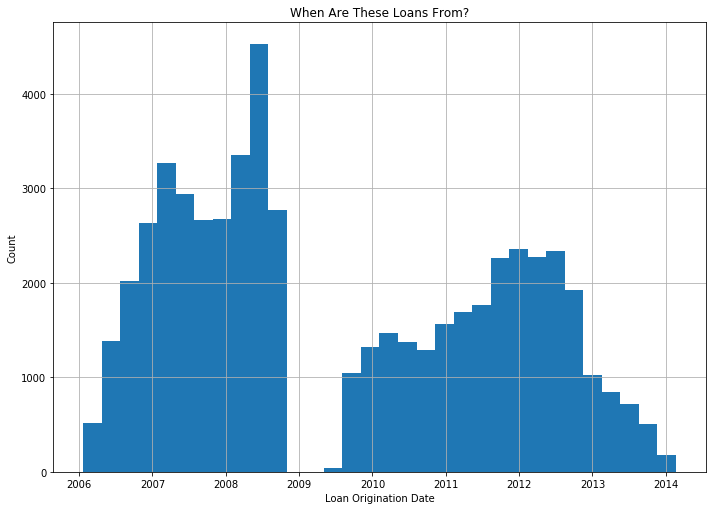

In [32]:
plt.figure(figsize=[ 11.69, 8.27])
df.LoanOriginationDate.hist(bins=32)
plt.title('When Are These Loans From?')
plt.xlabel('Loan Origination Date')
plt.ylabel('Count');

## How do loans tend to end?

The majority of loans are successfully completed, with a smaller amount charged-off and even less defaulted. This is good. While there is definite risk of a borrower failing to pay, *most* do. 

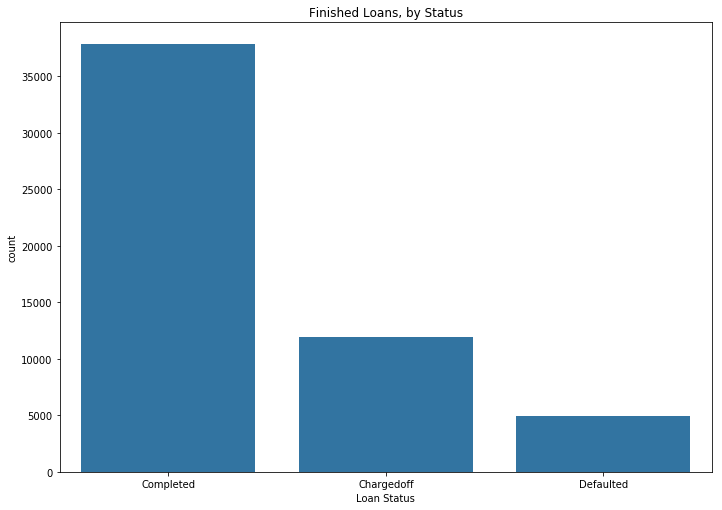

In [33]:
plt.figure(figsize=[ 11.69, 8.27])
sns.countplot(data = df, x = 'LoanStatus', color = base_color)

plt.title('Finished Loans, by Status')

plt.xlabel('Loan Status');

## Ratings

Prosper provides us with a rating system of the borrowers on their platform, ranging from 'AA', which is supposed to be the lowest risk, to 'HR', which literally stands for "High Risk".

We see the number of people on the platform grows as we reach middle ratings, before dropping for the highest risk ratings.


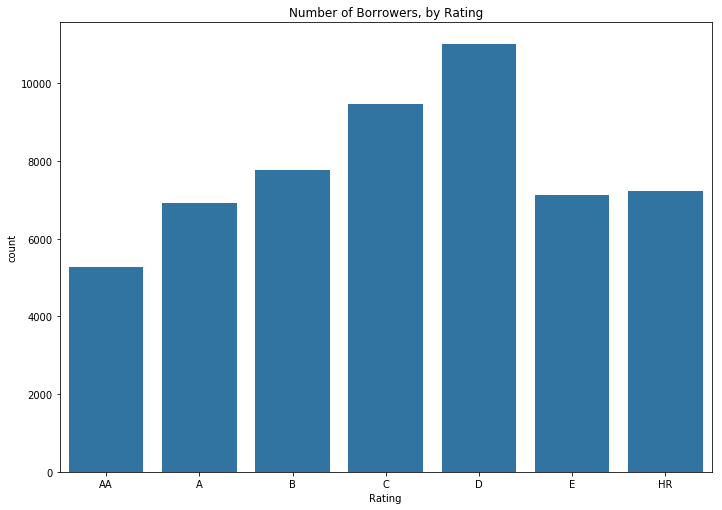

In [34]:
plt.figure(figsize=[ 11.69, 8.27])
sns.countplot(data = df, x = 'Rating', color = base_color)
plt.title('Number of Borrowers, by Rating');

## Is Rating useful?

Prosper's Ratings seem to do a pretty good job of judging risk. We see that 'AA' borrowers completed their loans slightly under 90% of the time, while 'HR' borrowers only completed them roughly 50% of the time.

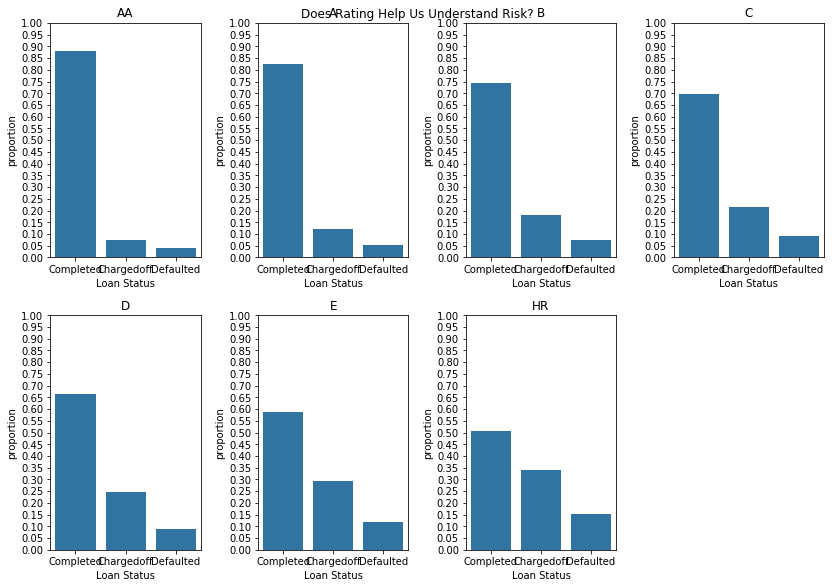

In [35]:

plt.figure(figsize=[ 11.69, 8.27])
i=1
for grade in df.Rating.cat.categories:

    plt.subplot(2,4,i)
    n_points = df[df.Rating == grade].shape[0]


    # generate tick mark locations and names
    tick_props = np.arange(0, 1.05, 0.05)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    # create the plot
    base_color = sns.color_palette()[0]
    sns.countplot(data=df[df.Rating == grade], x = 'LoanStatus', color = base_color)
    plt.yticks(tick_props * n_points, tick_names)

    plt.ylabel('proportion')
    plt.xlabel('Loan Status')
    plt.title(grade)
    
    i += 1
plt.suptitle('Does Rating Help Us Understand Risk?')
plt.tight_layout();

## Why would anyone chose lower Ratings?

Despite the increased risk, there is definitely a reward for lending to lower grade borrowers. They pay a much higher interest rate. 

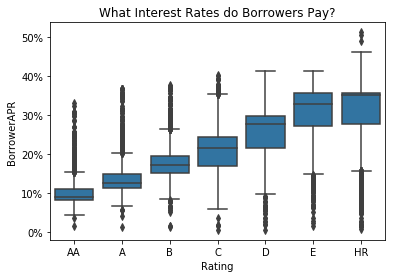

In [36]:
sns.boxplot(data = df, x = 'Rating', y = 'BorrowerAPR', color = base_color)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.title("What Interest Rates do Borrowers Pay?");

## Key Points So Far:

1. High-grade borrowers have **lower** risk, but pay **lower** interest.
2. Low-grade borrowers have **higher** risk, but pay **higher** interest.

At this point, if you plan on investing, you should feel comfortable using the borrower's rating to help guide your decisions. 

But what else can we glean from the data?

## Homeownership 

We can see that our dataset has a nice mix of homeowners and non-homeowners.

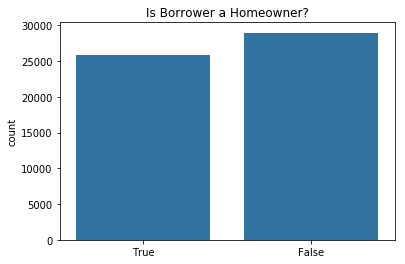

In [37]:
sns.countplot(data=df, x='IsBorrowerHomeowner', color=base_color, order=[True,False])
plt.xlabel('')
plt.title('Is Borrower a Homeowner?');

## What Ratings Do Homeowners and Non-Homeowners Have?

Homeownership definitely seems to correlate with better ratings. 

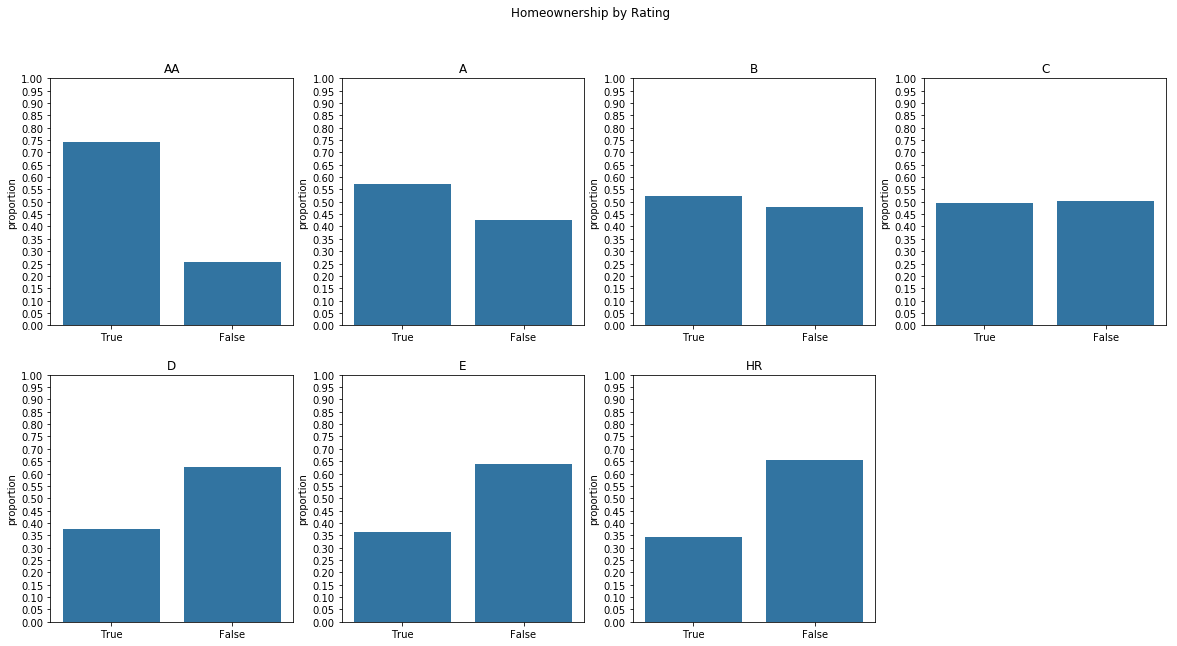

In [38]:
plt.figure(figsize = [20, 10])

i=1
for grade in df.Rating.cat.categories:

    plt.subplot(2,4,i)
    n_points = df[df.Rating == grade].shape[0]


    # generate tick mark locations and names
    tick_props = np.arange(0, 1.05, 0.05)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    # create the plot
    base_color = sns.color_palette()[0]
    sns.countplot(data=df[df.Rating == grade], x = 'IsBorrowerHomeowner', color = base_color, order=[True, False])
    plt.yticks(tick_props * n_points, tick_names)

    plt.ylabel('proportion')
    plt.xlabel('')
    plt.title(grade)
    i += 1
plt.suptitle('Homeownership by Rating');

## How does Homeownership impact Loan Status?

Interesting. The performance between the two groups is very minor. Homeowners did *slightly* better, but not by much. 



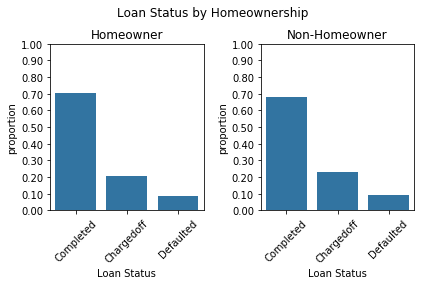

In [39]:
plt.subplot(1,2,1)
n_points = df[df['IsBorrowerHomeowner'] == True].shape[0]


# generate tick mark locations and names
tick_props = np.arange(0, 1.1, 0.1)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
   
# 1st graph
sns.countplot(data=df[df['IsBorrowerHomeowner'] == True], x = 'LoanStatus', color = base_color)
        
plt.xticks(rotation=45)
        
plt.yticks(tick_props * n_points, tick_names)
        
plt.ylabel('proportion')
plt.xlabel('Loan Status')
plt.title('Homeowner')
plt.tight_layout()


plt.subplot(1,2,2)
n_points = df[df['IsBorrowerHomeowner'] == False].shape[0]



# 2nd graph
sns.countplot(data=df[df['IsBorrowerHomeowner'] == False], x = 'LoanStatus', color = base_color)
        
plt.xticks(rotation=45)
        
plt.yticks(tick_props * n_points, tick_names)
        
plt.ylabel('proportion')
plt.xlabel('Loan Status')
plt.title('Non-Homeowner')
plt.suptitle('Loan Status by Homeownership')
plt.tight_layout()
plt.subplots_adjust(top=0.85)


## How has Homeownership's Loan Completion Rate changed over time?

Ah, now things are getting really interesting! While homeowners *usually* performed better, those taking out loans in late 2007 and 2008 actually did worse. This can probably be attributed to the [Great Recession](https://en.wikipedia.org/wiki/Great_Recession).

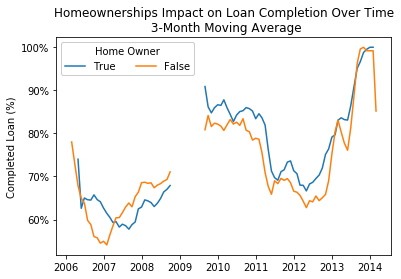

In [40]:
homeowner = completed_percent_by_time('IsBorrowerHomeowner')

plt.plot(homeowner.query('IsBorrowerHomeowner == True')['LoanOriginationDate'], homeowner.query('IsBorrowerHomeowner == True')['Completed'])
plt.plot(homeowner.query('IsBorrowerHomeowner == False')['LoanOriginationDate'], homeowner.query('IsBorrowerHomeowner == False')['Completed'])

plt.legend(loc = 0, ncol = 2, framealpha = 1, title = 'Home Owner', labels = ['True','False'])
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.ylabel('Completed Loan (%)')
plt.title('Homeownerships Impact on Loan Completion Over Time\n 3-Month Moving Average');


## Bringing Rating Back In

This trend seems to exist for all ratings.

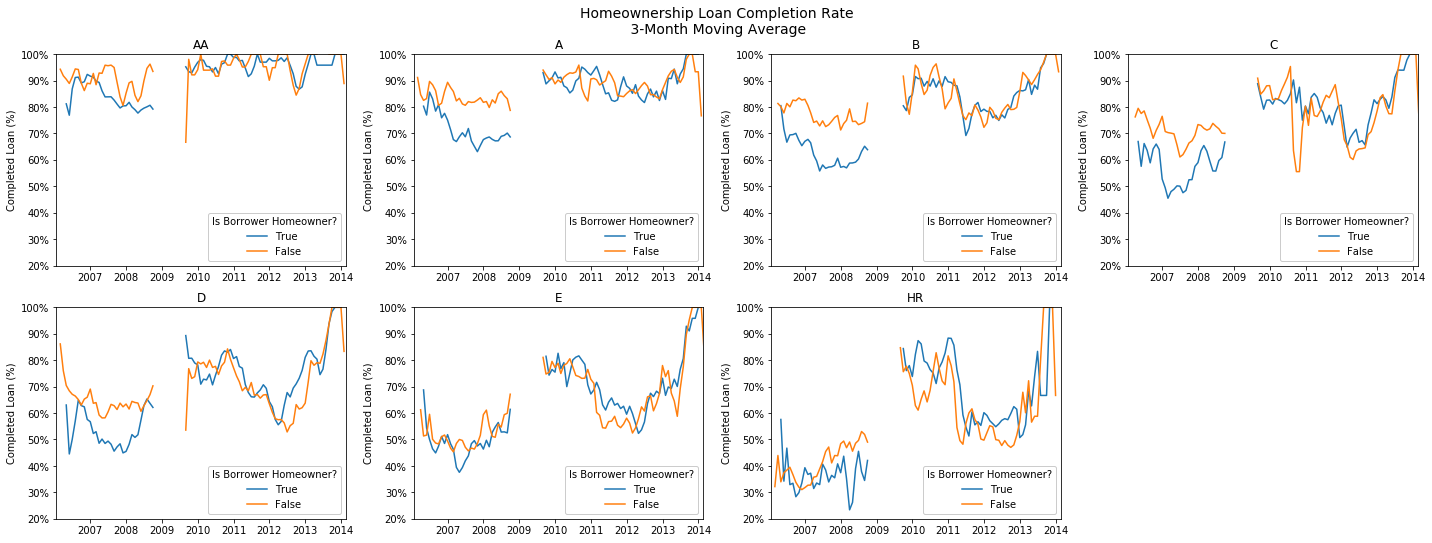

In [41]:
time_graph_facet('Rating','IsBorrowerHomeowner',order=[True,False],legend='Is Borrower Homeowner?')
plt.suptitle('Homeownership Loan Completion Rate\n 3-Month Moving Average', size=14)
plt.subplots_adjust(top=0.92);

## Insights

- We can use Prosper's ratings to help use judge the risk of a loan.
- While homeowner's were usually more likely to successfully complete their loans, in the lead up to the Great Recession, we found the opposite to be true.  

I personally find this second point very exciting.

In [ ]:
!jupyter nbconvert Prosper_Loan_Explanatory_Notebook.ipynb --to slides --post serve --template output_toggle

[NbConvertApp] Converting notebook Prosper_Loan_Explanatory_Notebook.ipynb to slides
[NbConvertApp] Writing 656728 bytes to Prosper_Loan_Explanatory_Notebook.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Prosper_Loan_Explanatory_Notebook.slides.html
Use Control-C to stop this server
